# Notebook to generate test outputs

In [2]:
import os

import idx2numpy
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

%matplotlib inline

In [3]:
# Constants.
LABEL_SIZE  = 10
SAMPLE_SIZE = 3
OUTPUT_PATH = "outputs/"

## Load images and labels

In [4]:
# Update the paths if needed.
file_image_path = "../../../Dataset/mnist/train-images-idx3-ubyte"
file_label_path = "../../../Dataset/mnist/train-labels-idx1-ubyte"

In [5]:
all_images = idx2numpy.convert_from_file(file_image_path)
all_images.shape

(60000, 28, 28)

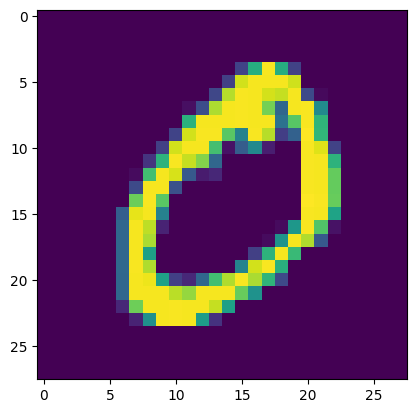

In [6]:
# Visualize an example.
plt.imshow(all_images[1])

In [7]:
all_labels = idx2numpy.convert_from_file(file_label_path)
all_labels.shape

(60000,)

In [8]:
all_labels[1]

np.uint8(0)

In `run_tests.cu`, the batch happens to have the first (ordered) 3 samples.

In [9]:
images = all_images[:SAMPLE_SIZE]
labels = all_labels[:SAMPLE_SIZE]
images.shape, labels.shape

((3, 28, 28), (3,))

In [10]:
# Convert the labels into one-hot encodings.
one_hot_labels = np.zeros((SAMPLE_SIZE, LABEL_SIZE))
for i in range(SAMPLE_SIZE):
    one_hot_labels[i, labels[i]] = 1
one_hot_labels

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

## Preprocessing images

In the test, we run two preprocessing steps on the images:

1) Normalize to 0..1
2) Add 2px padding

In [11]:
# Normalize images and convert to tensor.
train_X = torch.tensor(images / 255, requires_grad=True)
# Add padding and the input channel dimension.
train_X = torch.nn.ZeroPad2d(2)(train_X).unsqueeze(1).to(torch.float32)
train_X.shape

torch.Size([3, 1, 32, 32])

In [12]:
train_y = torch.tensor(one_hot_labels)
train_y.shape

torch.Size([3, 10])

## Load weights

In [13]:
linear_weights_file_path = "inputs/weights_linear.txt"
conv2d_weights_file_path = "inputs/weights_conv2d.txt"

In [14]:
def read_tensor_from_file(file_path: str) -> np.ndarray:
    file = open(file_path, "r")
    str_content = file.read()
    return torch.tensor([float(value) for value in str_content.split(",")])

In [15]:
linear_weights = read_tensor_from_file(linear_weights_file_path).reshape((LABEL_SIZE, 784))
conv2d_weights = read_tensor_from_file(conv2d_weights_file_path).reshape((4, 1, 5, 5))

## Run model for 1 iteration

The forward pass consists of the following layers:

- Convolution layer: 4 filters, each 5 x 5 --> output dim = 4 x 28 x 28
- Sigmoid layer
- Pooling layer: kernel size 2 x 2 --> output dim = 14 x 14
- Flatten layer --> output dim = 784 (4 filters x 14 x 14)
- Linear layer (784 x 10)
- Softmax layer

To compute loss, we use cross entropy loss on the *output of the linear layer*. Recall that cross entropy = log softmax + NLLLoss.

There are four sets of outputs we need for testing the C/CUDA code:

1) The output of each layer
2) The result of running loss
3) The gradients of each layer after running `.backward()`
4) The updated weights

Since the weights have been generated, we create custom classes for Conv2D and Linear layers to replace the weights.

In [16]:
class CustomWeightConv2D(torch.nn.Conv2d):
    def __init__(self, custom_weights):
        super(CustomWeightConv2D, self).__init__(custom_weights.shape[0], custom_weights.shape[1], custom_weights.shape[2], bias=False)
        self.weight = torch.nn.Parameter(custom_weights)

In [17]:
class CustomWeightLinear(torch.nn.Linear):
    def __init__(self, custom_weights):
         super(CustomWeightLinear, self).__init__(*custom_weights.shape, bias=False)
         self.weight = torch.nn.Parameter(custom_weights)

### Get output of each layer

In [18]:
layers = [
    CustomWeightConv2D(conv2d_weights),
    torch.nn.Sigmoid(),
    torch.nn.MaxPool2d(2),
    torch.nn.Flatten(),
    CustomWeightLinear(linear_weights),
    torch.nn.Softmax(dim=1),
]
layers_label = [
    "layer0_conv2d",
    "layer1_sigmoid",
    "layer2_maxpool",
    "layer3_flatten",
    "layer4_linear",
    "layer5_softmax",
]

In [19]:
layers_output = []
for layer_i, layer in enumerate(layers):
    if layer_i == 0:
        layers_output.append(layer(train_X))
    else:
        layers_output.append(layer(layers_output[layer_i - 1]))
    layers_output[layer_i].retain_grad()

### Get loss value

In [20]:
loss = torch.nn.CrossEntropyLoss()
loss_output = loss(layers_output[4], train_y)
loss_output

tensor(1.9225, dtype=torch.float64, grad_fn=<DivBackward1>)

In [21]:
np.savetxt(os.path.join(OUTPUT_PATH, f"output_loss.txt"), loss_output.detach().numpy().flatten())

In [22]:
loss_output.backward()

In [23]:
for layer_label, layer_output in zip(layers_label, layers_output):
    np.savetxt(os.path.join(OUTPUT_PATH, f"output_{layer_label}.txt"), layer_output.detach().numpy().flatten())

### Get gradients of each layer output/weight

In [25]:
for layer_label, layer_output in zip(layers_label[:-1], layers_output[:-1]):
    print(f"{layer_label}\tgrad dim: ", layer_output.grad.shape)
    np.savetxt(os.path.join(OUTPUT_PATH, f"dy_{layer_label}.txt"), layer_output.grad.detach().numpy().flatten())

layer0_conv2d	grad dim:  torch.Size([3, 4, 28, 28])
layer1_sigmoid	grad dim:  torch.Size([3, 4, 28, 28])
layer2_maxpool	grad dim:  torch.Size([3, 4, 14, 14])
layer3_flatten	grad dim:  torch.Size([3, 784])
layer4_linear	grad dim:  torch.Size([3, 10])


In [26]:
# Store conv2d weight grad.
print(layers[0].weight.grad.shape)
np.savetxt(os.path.join(OUTPUT_PATH, f"weight_grad_layer0_conv2d.txt"), layers[0].weight.grad.detach().numpy().flatten())

torch.Size([4, 1, 5, 5])


In [27]:
# Store linear weight grad.
print(layers[4].weight.grad.shape)
np.savetxt(os.path.join(OUTPUT_PATH, f"weight_grad_layer4_linear.txt"), layers[4].weight.grad.detach().numpy().flatten())

torch.Size([10, 784])
